# Preprocessing, Step 0 bis Step 7 + Regression


In [1]:
import os
from pathlib import Path
import seaborn as sns  
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
import missingno as msno
from sklearn import linear_model
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

In [2]:
df = pd.read_csv('../../data/raw/triathlon_watch_training_data_final.csv')
# Rename columns for better handling
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
df.info

<bound method DataFrame.info of         id  age_of_customer     sex       ctry        town  \
0    C0001             61.0   Other         UK  Birmingham   
1    C0003             57.0   Other  Australia      Sydney   
2    C0004             30.0   Other      India   Bangalore   
3    C0005             21.0    Male    Germany      Munich   
4    C0006             63.0    Male      India      Mumbai   
..     ...              ...     ...        ...         ...   
995  C0996             28.0  Female  Australia    Brisbane   
996  C0997             54.0  Female  Australia   Melbourne   
997  C0998             35.0   Other        USA    New York   
998  C0999             31.0   Other    Germayn      Berlin   
999  C1000             27.0    Male      India      Mumbai   

     swimming_hours_per_week  biking_hours_per_week  running_hours_per_week  \
0                       2.52                   0.10                    1.78   
1                       1.55                  10.01              

In [3]:
# Spalte ID wird das führende "C" entfernt und die führenden Nullen
df["id"] = df["id"].dropna().str.replace("C", "", regex=True).astype(int)

In [4]:
# Sicherstellen, dass die Spalte als Datumsformat erkannt wird
df["most_current_software_update"] = pd.to_datetime(df["most_current_software_update"], format="%Y-%m-%d")
# ✅ Differenz zum jüngsten Datum berechnen (in Tagen)
latest_date = df["most_current_software_update"].max()
df["days_since_latest_update"] = (latest_date - df["most_current_software_update"]).dt.days
# Ergebnis ausgeben
print(df[["most_current_software_update", "days_since_latest_update"]].head())

  most_current_software_update  days_since_latest_update
0                   2024-07-22                     163.0
1                   2024-05-11                     235.0
2                   2024-08-16                     138.0
3                   2024-08-11                     143.0
4                   2024-11-18                      44.0


In [5]:
# Monat als Namen speichern (z. B. "Juli", "Mai")
df["update_month_name"] = df["most_current_software_update"].dt.strftime("%B")
# Spalte "most_current_software_update" entfernen
df = df.drop(columns=["most_current_software_update"])

In [6]:
numeric=df.select_dtypes(include=['float64']).columns.tolist() #list of numeric columns
categorical = df.select_dtypes(include=['object']).columns.to_list() #append all categorical columns to a list

In [7]:
print(df.dtypes)

id                               float64
age_of_customer                  float64
sex                               object
ctry                              object
town                              object
swimming_hours_per_week          float64
biking_hours_per_week            float64
running_hours_per_week           float64
total_training_hours_per_week    float64
vo2_max                          float64
10k_running_time_prediction      float64
calories_burned_per_week         float64
support_cases_of_customer        float64
customer_years                   float64
goal_of_training                  object
preferred_training_daytime        object
subscription_type                 object
color_of_watch                    object
synchronisation                   object
user_of_latest_model             float64
days_since_latest_update         float64
update_month_name                 object
dtype: object


**bis hierin wurde nur ganz einfache Veränderungen vollzogen. df ist nun die Grundlage für die weietren Steps**

# Step 0 Simple Preprocessing

In [8]:
df_step0 =df.copy()

In [9]:

target_column = "user_of_latest_model" if "user_of_latest_model" in df_step0.columns else df.columns[-1]
# Zeilen mit fehlenden Werten in der Zielvariable entfernen
df_step0 = df_step0.dropna(subset=[target_column])
# Zeilen mit mehr als zwei fehlenden Werten entfernen
df_step0 = df_step0[df_step0.isnull().sum(axis=1) <= 2]

In [10]:
# Fehlende Werte analysieren
missing_values = df_step0.isnull().sum()
missing_values = missing_values[missing_values > 0]

# Fehlende Werte durch Durchschnitt (numerisch) oder Modus (kategorisch) ersetzen
#df_step0 = df_step0.copy()

numeric_cols = df_step0.select_dtypes(include=[np.number]).columns
categorical_cols = df_step0.select_dtypes(exclude=[np.number]).columns

for col in numeric_cols:
    df_step0[col] = df_step0[col].fillna(df_step0[col].mean())

for col in categorical_cols:
    df_step0[col] = df_step0[col].fillna(df_step0[col].mode()[0])

# Speichern der bereinigten Daten
output_path = "triathlon_watch_training_data_step0.csv"
df_step0.to_csv(output_path, index=False)

# Ergebnis anzeigen
print("Step 0 abgeschlossen. Bereinigte Daten gespeichert unter:", output_path)
print(df_step0.head())



Step 0 abgeschlossen. Bereinigte Daten gespeichert unter: triathlon_watch_training_data_step0.csv
    id  age_of_customer    sex       ctry        town  \
0  1.0             61.0  Other         UK  Birmingham   
1  3.0             57.0  Other  Australia      Sydney   
2  4.0             30.0  Other      India   Bangalore   
3  5.0             21.0   Male    Germany      Munich   
4  6.0             63.0   Male      India      Mumbai   

   swimming_hours_per_week  biking_hours_per_week  running_hours_per_week  \
0                     2.52                   0.10                    1.78   
1                     1.55                  10.01                    4.57   
2                     1.19                  12.04                    8.64   
3                     2.25                   4.67                    0.92   
4                     0.80                   5.88                    0.67   

   total_training_hours_per_week  vo2_max  ...  support_cases_of_customer  \
0                  

In [12]:
numerical_columns = df_step0.select_dtypes(include=['number']).columns.tolist()
categorical_columns = df_step0.select_dtypes(exclude=['number']).columns.tolist()

print("📊 Numerische Spalten:", numerical_columns)
print("🔠 Kategoriale Spalten:", categorical_columns)


📊 Numerische Spalten: ['id', 'age_of_customer', 'swimming_hours_per_week', 'biking_hours_per_week', 'running_hours_per_week', 'total_training_hours_per_week', 'vo2_max', '10k_running_time_prediction', 'calories_burned_per_week', 'support_cases_of_customer', 'customer_years', 'user_of_latest_model', 'days_since_latest_update']
🔠 Kategoriale Spalten: ['sex', 'ctry', 'town', 'goal_of_training', 'preferred_training_daytime', 'subscription_type', 'color_of_watch', 'synchronisation', 'update_month_name']


## Regression als Funktion

In [13]:
df_score = pd.DataFrame(columns=['arbeitsschritt', 'Accuracy', 'F1-Score'])

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# Initialize DataFrame to store results
#df_score = pd.DataFrame(columns=['arbeitsschritt', 'Accuracy', 'F1-Score'])


def run_logistic_regression(df, arbeitsschritt):
    global df_score
    # Trennen von Features und Zielvariable
    target_column = 'user_of_latest_model'
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Identifikation der kategorischen Variablen
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns

    # One-Hot-Encoding für kategoriale Variablen
    encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    X_encoded = pd.DataFrame(
        encoder.fit_transform(X[categorical_cols]),
        columns=encoder.get_feature_names_out(categorical_cols),
        index=X.index
    )

    # Numerische Spalten beibehalten
    X_numeric = X.drop(columns=categorical_cols)

    # Zusammenfügen der numerischen und encodierten Daten
    X_final = pd.concat([X_numeric, X_encoded], axis=1)
    
    # Aufteilen in Trainings- und Testset
    X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42, stratify=y)

    model = LogisticRegression(
        solver='liblinear',   # Guter Standard für kleine/mittelgroße Daten
        #solver='lbfgs' ,       # ebenfalls für kleine Daten
        #penalty='l2',         # Feature-Selektion, wenn auskommentiert wird automatisch l2 genommen
        #C=0.5,                # Moderate Regularisierung
        #class_weight='balanced', # Falls die Klassen unausgeglichen sind
        max_iter=500,         # Erhöhte Iterationen für Stabilität
        random_state=42       # Reproduzierbarkeit
    )
    model.fit(X_train, y_train)

    # Vorhersagen
    y_pred = model.predict(X_test)

    # Metriken berechnen
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}, F1-Score: {f1:.2f}")
    
    # Neue Zeile zur bestehenden DataFrame hinzufügen
    new_row = pd.DataFrame({
        "arbeitsschritt": [arbeitsschritt],
        "Accuracy": [accuracy],
        "F1-Score": [f1]
    })
    df_score = pd.concat([df_score, new_row], ignore_index=True)

    return model, df_score



In [ ]:
run_logistic_regression(df_step0, '0 Simple Preprocessing')
df_score

Accuracy: 0.77, F1-Score: 0.71


C:\Users\laukat\AppData\Local\Temp\ipykernel_63780\3526106794.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_score = pd.concat([df_score, new_row], ignore_index=True)


,arbeitsschritt,Accuracy,F1-Score
0,step 0,0.770408,0.709677


# Step 1 Data Quality Correction

In [17]:
df_step1 = df_step0.copy()

In [18]:
# Überblick über das Feature "ctry"
ctry_overview = df_step1['ctry'].value_counts()
# Ergebnis anzeigen
print(ctry_overview)

# Korrigiere den Ländernamen "Germayn" zu "Germany"
df_step1['ctry'] = df_step1['ctry'].replace('Germayn', 'Germany')

# Überprüfen, ob die Änderung erfolgreich war
ctry_overview = df_step1['ctry'].value_counts()
print(ctry_overview)

ctry
Australia      200
USA            199
UK             191
India          186
Germany        179
Germayn         19
UnknownLand      4
Name: count, dtype: int64
ctry
Australia      200
USA            199
Germany        198
UK             191
India          186
UnknownLand      4
Name: count, dtype: int64


In [19]:
# Doppelte Datensätze anzeigen
duplicate_rows = df_step1[df_step1.duplicated()]
print("Doppelte Datensätze:")
print(duplicate_rows)

# Doppelte Datensätze entfernen
df_step1 = df_step1.drop_duplicates()
print("Doppelte Datensätze wurden entfernt.")

Doppelte Datensätze:
        id  age_of_customer    sex       ctry        town  \
642  640.0             29.0  Other  Australia   Melbourne   
714  708.0             55.0  Other         UK  Birmingham   

     swimming_hours_per_week  biking_hours_per_week  running_hours_per_week  \
642                     5.06                   1.44                    0.25   
714                     0.40                   5.89                    2.07   

     total_training_hours_per_week  vo2_max  ...  support_cases_of_customer  \
642                           6.75    54.86  ...                        0.0   
714                           8.37    40.73  ...                        0.0   

     customer_years  goal_of_training  preferred_training_daytime  \
642             3.0           Fitness                     Evening   
714             7.0        Recreation                     Morning   

    subscription_type color_of_watch synchronisation user_of_latest_model  \
642             Basic          Bla

In [ ]:
run_logistic_regression(df_step1, '1 Data Quality Correction')
df_score

Accuracy: 0.76, F1-Score: 0.71


,arbeitsschritt,Accuracy,F1-Score
0,step 0,0.770408,0.709677
1,step 1,0.760204,0.711656


# Step 2 Missing Value Handling

In [22]:
df_step2 = df.copy()

<Axes: >

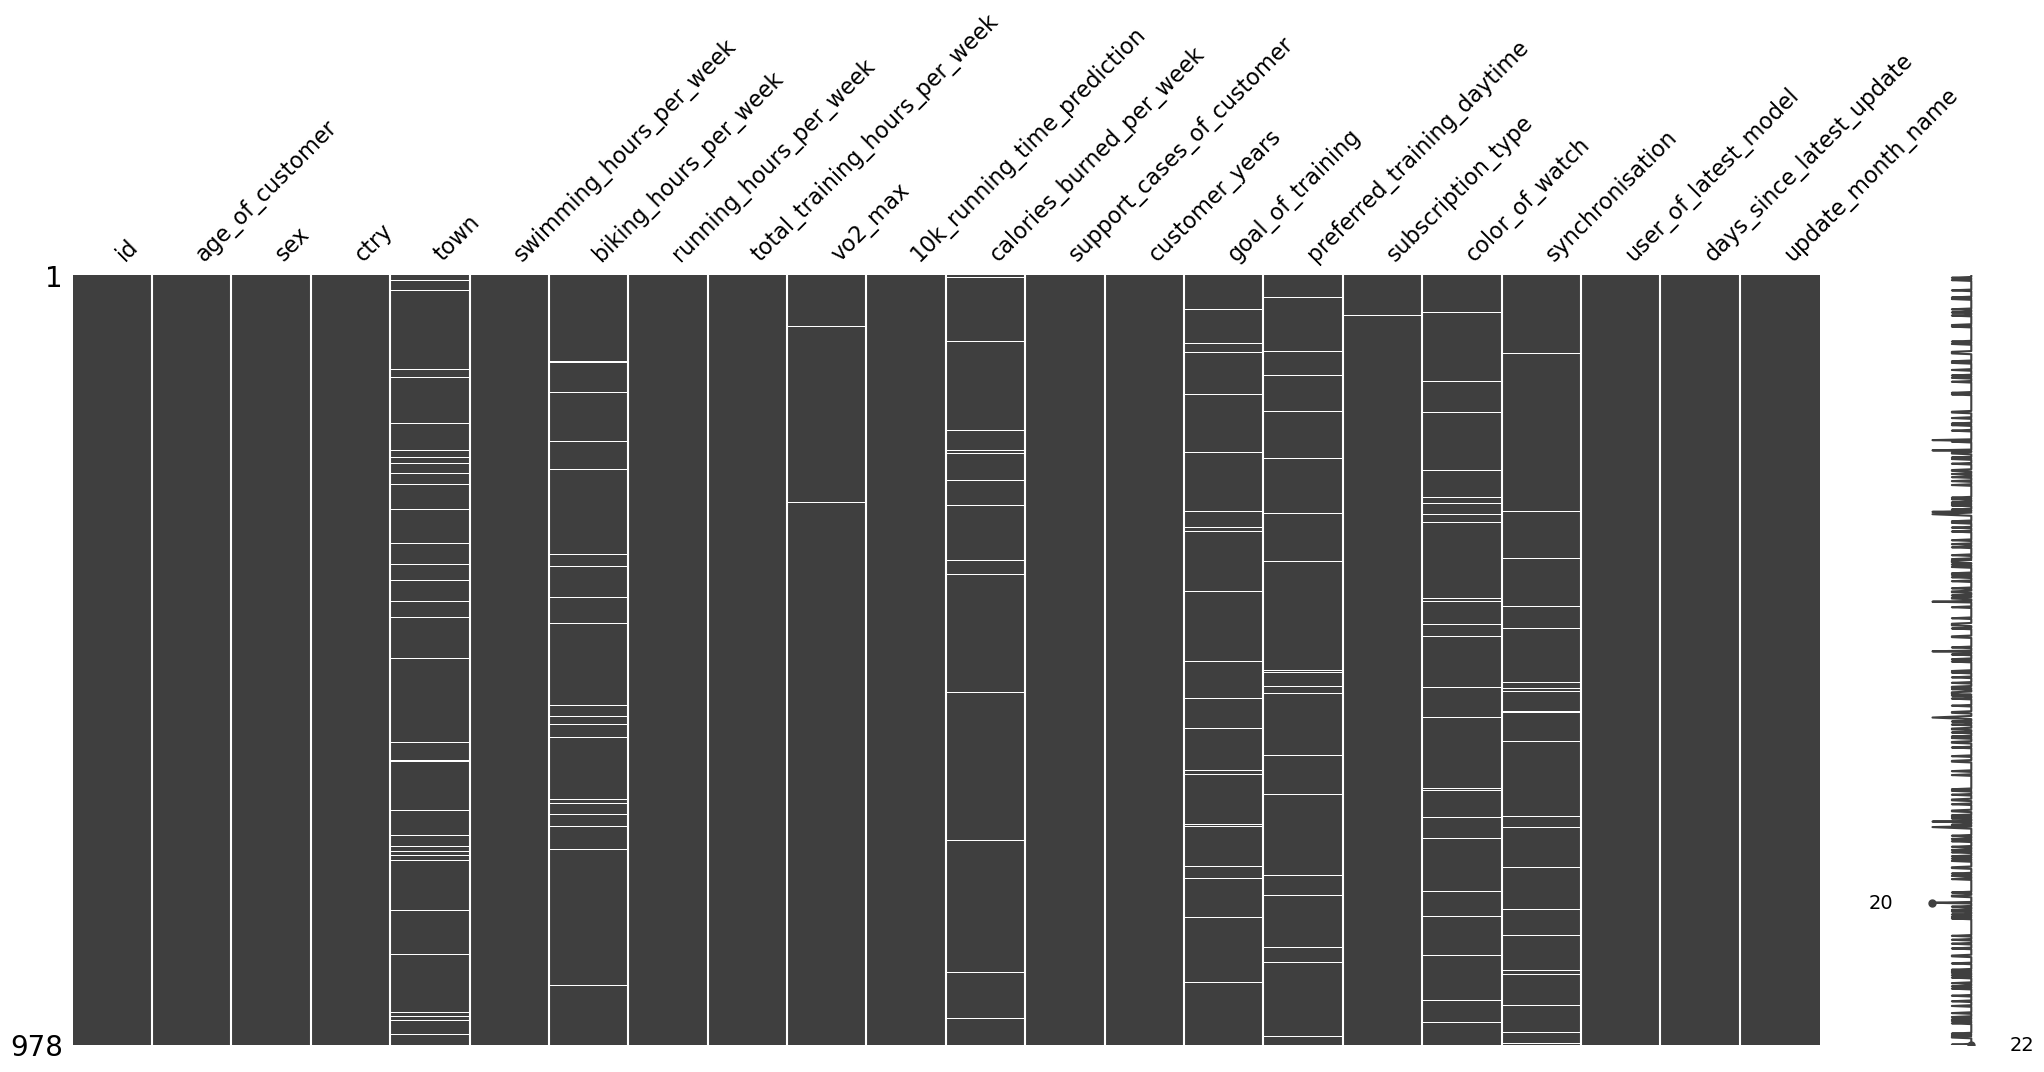

In [23]:
#Listwise deletion all rows with missing values in the column 'user_of_latest_model'
df_step2=df_step2.drop(df_step2[df_step2['user_of_latest_model'].isnull()].index)
msno.matrix(df_step2)

In [24]:
df_step2[numeric].isnull().sum()

id                                0
age_of_customer                   0
swimming_hours_per_week           0
biking_hours_per_week            24
running_hours_per_week            0
total_training_hours_per_week     0
vo2_max                           4
10k_running_time_prediction       0
calories_burned_per_week         19
support_cases_of_customer         0
customer_years                    0
user_of_latest_model              0
days_since_latest_update          1
dtype: int64

In [25]:
correlation_with_A = df_step2[numeric].corr()['biking_hours_per_week'].drop('biking_hours_per_week')  # Entferne die Korrelation mit sich selbst

# Ausgabe der Korrelation
print(correlation_with_A)

id                              -0.023415
age_of_customer                  0.001405
swimming_hours_per_week          0.133546
running_hours_per_week           0.162726
total_training_hours_per_week    0.530162
vo2_max                          0.164993
10k_running_time_prediction     -0.159664
calories_burned_per_week         0.804664
support_cases_of_customer        0.030294
customer_years                   0.008436
user_of_latest_model             0.228377
days_since_latest_update        -0.014664
Name: biking_hours_per_week, dtype: float64


In [26]:
#  Iterative Imputation for numeric columns
imputer = IterativeImputer(max_iter=30, tol=1e-2, random_state=42, initial_strategy='median') #initial all missing values were replaced by median
df_step2_numeric_imputed = pd.DataFrame(imputer.fit_transform(df_step2[numeric])) # creating a new dataframe with imputed values

df_step2_numeric_imputed.index = df_step2.index # adapt index of new dataframe to index of original dataframe
df_step2[numeric] = df_step2_numeric_imputed # replace numeric columns in original dataframe with imputed values

print(df_step2[numeric].isnull().sum()) # check if all missing values in numeric columns were imputed

id                               0
age_of_customer                  0
swimming_hours_per_week          0
biking_hours_per_week            0
running_hours_per_week           0
total_training_hours_per_week    0
vo2_max                          0
10k_running_time_prediction      0
calories_burned_per_week         0
support_cases_of_customer        0
customer_years                   0
user_of_latest_model             0
days_since_latest_update         0
dtype: int64


In [27]:
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

# 1. Kategorische Spalten in numerische Werte umwandeln
label_encoders = {}  # Dictionary, um die LabelEncoder zu speichern

for col in categorical:
    if df_step2[col].dtype == 'object':  # Überprüfen, ob es sich um eine kategorische Spalte handelt
        encoder = LabelEncoder()
        df_step2[col] = encoder.fit_transform(df_step2[col].fillna('Missing'))  # Umwandlung und fehlende Werte ersetzen
        label_encoders[col] = encoder  # Speichern des Encoders

# 2. KNN-Imputation auf den numerischen Werten anwenden
imputer = KNNImputer(n_neighbors=2)  # Anzahl der Nachbarn (k) einstellen
df_imputed_categorical = pd.DataFrame(imputer.fit_transform(df_step2[categorical]), columns=categorical)

# 3. Imputierte Werte zurück in kategorische Werte umwandeln
for col, encoder in label_encoders.items():
    df_imputed_categorical[col] = encoder.inverse_transform(df_imputed_categorical[col].round().astype(int))  # Rückumwandlung

# Ausgabe des imputierten DataFrames
df_imputed_categorical

df_imputed_categorical.index = df_step2.index # adapt index of new dataframe to index of original dataframe
df_step2[categorical] = df_imputed_categorical # replace numeric columns in original dataframe with imputed values

print(df_step2.isnull().sum()) # check if all missing values in numeric columns were imputed

id                               0
age_of_customer                  0
sex                              0
ctry                             0
town                             0
swimming_hours_per_week          0
biking_hours_per_week            0
running_hours_per_week           0
total_training_hours_per_week    0
vo2_max                          0
10k_running_time_prediction      0
calories_burned_per_week         0
support_cases_of_customer        0
customer_years                   0
goal_of_training                 0
preferred_training_daytime       0
subscription_type                0
color_of_watch                   0
synchronisation                  0
user_of_latest_model             0
days_since_latest_update         0
update_month_name                0
dtype: int64


In [ ]:
run_logistic_regression(df_step2, '2 Missing Value Handling')
df_score

Accuracy: 0.77, F1-Score: 0.71


,arbeitsschritt,Accuracy,F1-Score
0,step 0,0.770408,0.709677
1,step 1,0.760204,0.711656
2,step 2,0.770408,0.705882


# Step 3 Outliers

In [29]:
df_step3 = df_step0.copy()

#  Detection of outliers with IQR-method
def detect_outliers_iqr(df):
    df_outliers = df.copy()
    for col in df.select_dtypes(include=np.number):  # Nur numerische Spalten
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_outliers[col] = df[col].apply(lambda x: np.nan if x < lower_bound or x > upper_bound else x)
    return df_outliers


#  Replacement of outliers mit NaN
data_numeric_no_outliers = detect_outliers_iqr(df_step3[numeric])

data_numeric_no_outliers.isnull().sum()

id                                0
age_of_customer                   0
swimming_hours_per_week          13
biking_hours_per_week             7
running_hours_per_week           12
total_training_hours_per_week    13
vo2_max                          18
10k_running_time_prediction      12
calories_burned_per_week         12
support_cases_of_customer         0
customer_years                    0
user_of_latest_model              0
days_since_latest_update          0
dtype: int64

In [30]:
#  Iterative Imputation for numeric columns
imputer = IterativeImputer(max_iter=30, tol=1e-2, random_state=42, initial_strategy='median') #initial all missing values were replaced by median
data_numeric_imputed = pd.DataFrame(imputer.fit_transform(data_numeric_no_outliers)) # creating a new dataframe with imputed values

data_numeric_imputed.index = df_step3.index # adapt index of new dataframe to index of original dataframe
#df_imputed_numeric = df_step3.copy() # create a copy of the original dataframe
df_step3[numeric] = data_numeric_imputed # replace numeric columns in original dataframe with imputed values

print(df_step3[numeric].isnull().sum()) # check if all missing values in numeric columns were imputed

id                               0
age_of_customer                  0
swimming_hours_per_week          0
biking_hours_per_week            0
running_hours_per_week           0
total_training_hours_per_week    0
vo2_max                          0
10k_running_time_prediction      0
calories_burned_per_week         0
support_cases_of_customer        0
customer_years                   0
user_of_latest_model             0
days_since_latest_update         0
dtype: int64


In [ ]:
run_logistic_regression(df_step3, '3 Outliers')
df_score

Accuracy: 0.77, F1-Score: 0.71


,arbeitsschritt,Accuracy,F1-Score
0,step 0,0.770408,0.709677
1,step 1,0.760204,0.711656
2,step 2,0.770408,0.705882
3,step 3,0.770408,0.709677


# Step 4 Transformation Normalverteilung

In [39]:
df_step4 = df_step0.copy()

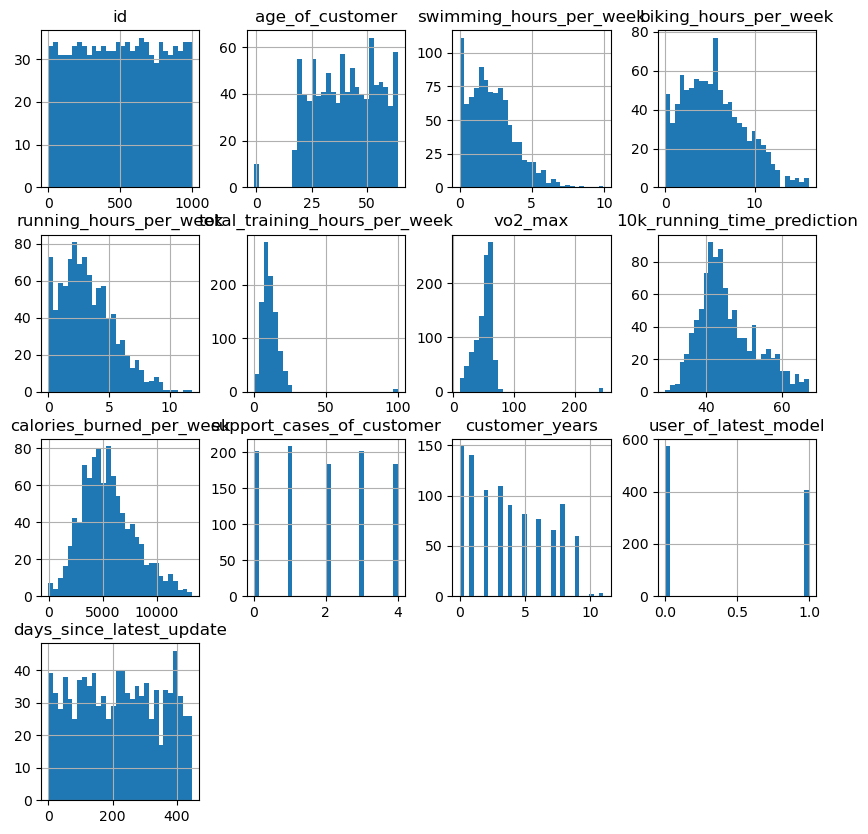

In [41]:
# Showing the distribution of the numerical data with histograms
%matplotlib inline
hist = df_step4[numeric].hist(bins=30,figsize=(10, 10))

In [42]:
numeric_ohne_target = numeric.copy()
numeric_ohne_target.remove('user_of_latest_model')

Der Hauptzweck dieser Transformation ist:
Umwandlung nicht-normalverteilter Daten in normalverteilte Daten
Reduzierung des Einflusses von Ausreißern
Verbesserung der Performance von Machine Learning Modellen, die von normalverteilten Daten profitieren
Standardisierung der Datenverteilung über alle numerischen Features

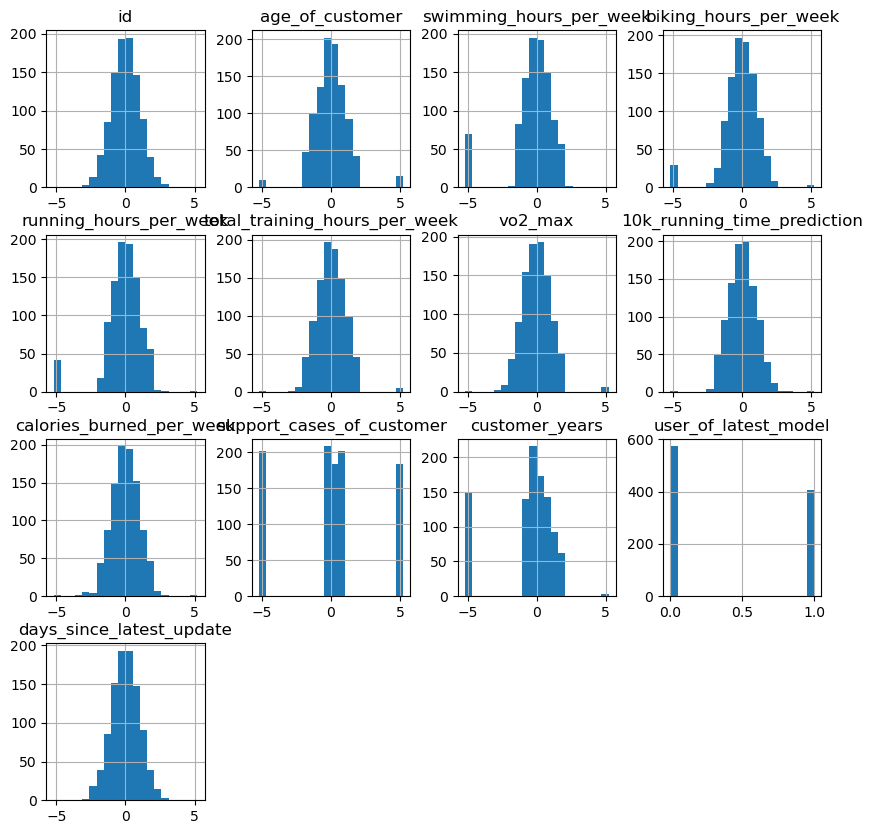

In [43]:
from sklearn.preprocessing import QuantileTransformer

#Erstellt einen Transformer, der die Daten in eine Normalverteilung überführt
qt = QuantileTransformer(n_quantiles=25, output_distribution='normal', random_state=0)

#Lernt die Transformation aus den Daten und wendet sie direkt an
#Transformiert alle numerischen Spalten außer 'user_of_latest_model'
#Das Ergebnis ist eine NumPy-Array mit den transformierten Werten
trans_x = qt.fit_transform(df_step4[numeric_ohne_target])  

#Wandelt die transformierte Array wieder in einen DataFrame um
#Ersetzt die ursprünglichen Werte im DataFrame mit den transformierten Werten
#Behält die Index-Struktur bei
df_step4[numeric_ohne_target] = pd.DataFrame(trans_x, columns=numeric_ohne_target, index=df_step4.index)

# Plot histograms for each numerical column to visualize the distribution
df_step4[numeric].hist(bins=20, figsize=(10, 10))
plt.show()


In [ ]:
run_logistic_regression(df_step4, '4 Transformation Normalverteilung')
df_score

Accuracy: 0.75, F1-Score: 0.69


,arbeitsschritt,Accuracy,F1-Score
0,step 0,0.770408,0.709677
1,step 1,0.760204,0.711656
2,step 2,0.770408,0.705882
3,step 3,0.770408,0.709677
4,step 4,0.750000,0.687898


# Step 5 Power Transformation

In [48]:
df_step5 = df_step0.copy()

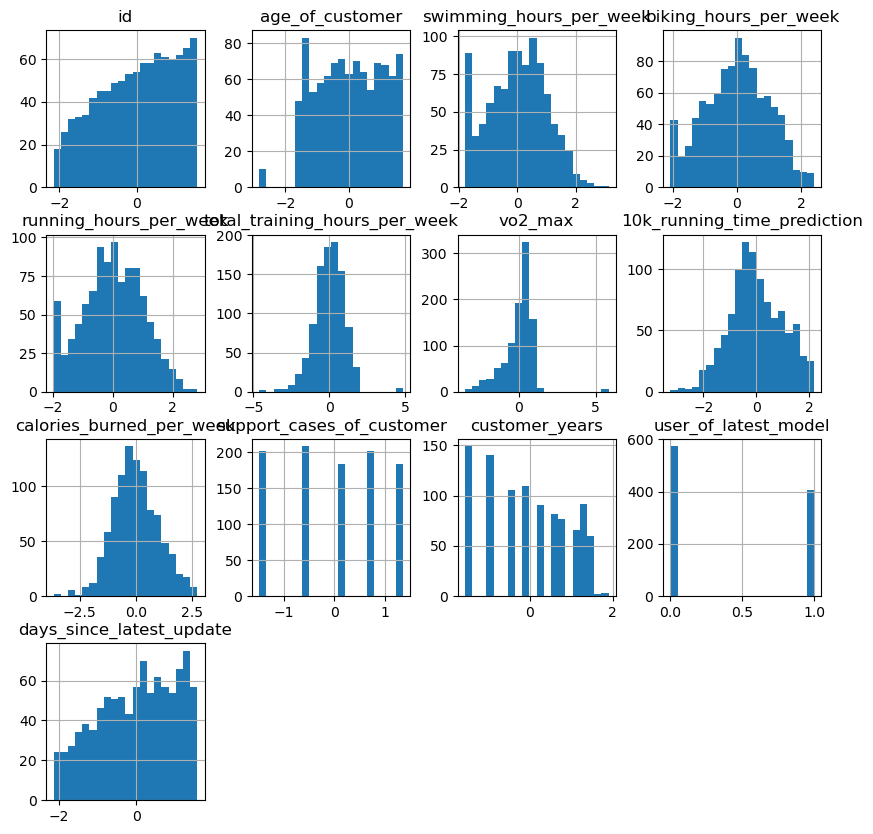

In [49]:
from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt

# Initialize PowerTransformer (Yeo-Johnson is default, Box-Cox requires only positive data)
pt = PowerTransformer(method='yeo-johnson', standardize=True)  

# Apply the transformation to all numerical columns
trans_x = pt.fit_transform(df_step5[numeric_ohne_target])  

# Convert the transformed array back to a DataFrame and replace original numerical columns
df_step5[numeric_ohne_target] = pd.DataFrame(trans_x, columns=numeric_ohne_target, index=df_step5.index)

# Plot histograms for each numerical column to visualize the distribution
df_step5[numeric].hist(bins=20, figsize=(10, 10))
plt.show()

In [ ]:
run_logistic_regression(df_step5, '5 Power Transformation')
df_score

Accuracy: 0.77, F1-Score: 0.71


,arbeitsschritt,Accuracy,F1-Score
0,step 0,0.770408,0.709677
1,step 1,0.760204,0.711656
2,step 2,0.770408,0.705882
3,step 3,0.770408,0.709677
4,step 4,0.750000,0.687898
5,step 5,0.765306,0.705128


# Step 6 Min-Max-Scaler

In [51]:
df_step6 = df_step0.copy()

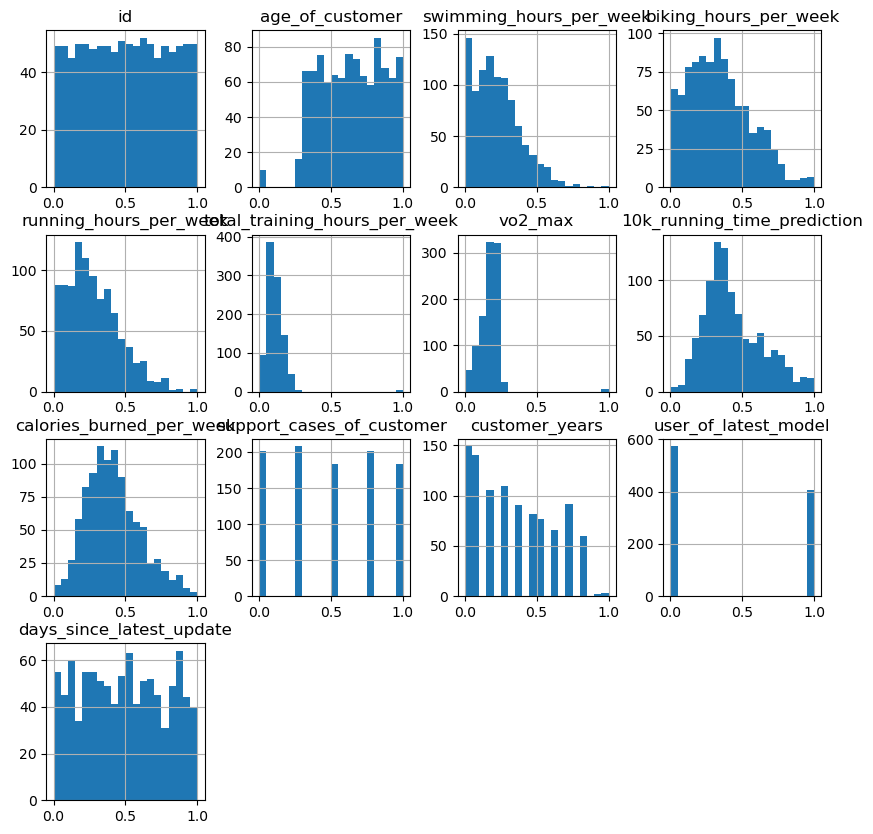


Min-Max Werte nach der Skalierung:
id:
Min: 0.00
Max: 1.00

age_of_customer:
Min: 0.00
Max: 1.00

swimming_hours_per_week:
Min: 0.00
Max: 1.00

biking_hours_per_week:
Min: 0.00
Max: 1.00

running_hours_per_week:
Min: 0.00
Max: 1.00

total_training_hours_per_week:
Min: 0.00
Max: 1.00

vo2_max:
Min: 0.00
Max: 1.00

10k_running_time_prediction:
Min: 0.00
Max: 1.00

calories_burned_per_week:
Min: 0.00
Max: 1.00

support_cases_of_customer:
Min: 0.00
Max: 1.00

customer_years:
Min: 0.00
Max: 1.00

days_since_latest_update:
Min: 0.00
Max: 1.00



In [52]:
from sklearn.preprocessing import MinMaxScaler

# Initialisiere den MinMaxScaler
scaler = MinMaxScaler()

# Transformiere die numerischen Spalten (ohne das Label)
scaled_features = scaler.fit_transform(df_step6[numeric_ohne_target])

# Konvertiere die transformierten Daten zurück in einen DataFrame mit den ursprünglichen Spaltennamen
df_step6[numeric_ohne_target] = pd.DataFrame(scaled_features, 
                                            columns=numeric_ohne_target, 
                                            index=df_step6.index)

# Visualisiere die Verteilung der skalierten Daten
df_step6[numeric].hist(bins=20, figsize=(10, 10))
plt.show()

# Optional: Überprüfung der Skalierung
print("\nMin-Max Werte nach der Skalierung:")
for column in numeric_ohne_target:
    print(f"{column}:")
    print(f"Min: {df_step6[column].min():.2f}")
    print(f"Max: {df_step6[column].max():.2f}\n")

In [ ]:
run_logistic_regression(df_step6, '6 MIN-MAX-Scaler')
df_score

Accuracy: 0.77, F1-Score: 0.70


,arbeitsschritt,Accuracy,F1-Score
0,step 0,0.770408,0.709677
1,step 1,0.760204,0.711656
2,step 2,0.770408,0.705882
3,step 3,0.770408,0.709677
4,step 4,0.750000,0.687898
5,step 5,0.765306,0.705128
6,step 6,0.765306,0.701299


# Step 7 Standard-Scaler

In [55]:
df_step7 = df_step0.copy()

StandardScaler transformiert die Daten so, dass:
Mittelwert = 0
Standardabweichung = 1
Die Werte sind nicht auf einen bestimmten Bereich beschränkt
Die Transformation erfolgt nach der Formel: z = (x - μ) / σ

Erstellt eine Kopie von df_step4
Führt die Standardisierung der numerischen Features durch
Behält die Zielvariable unverändert
Visualisiert die Verteilungen
Überprüft die erfolgreiche Standardisierung durch Ausgabe von Mittelwert und Standardabweichung

Die standardisierten Werte sollten nun:

Einen Mittelwert nahe 0 haben
Eine Standardabweichung nahe 1 haben
Die ursprüngliche Verteilungsform beibehalten

<Figure size 1000x1000 with 0 Axes>

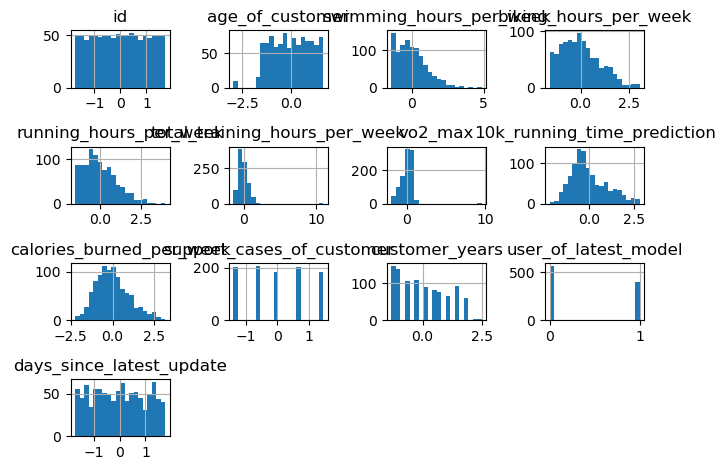


Überprüfung der Standardisierung (Mean ≈ 0, Std ≈ 1):

id:
Mittelwert: 0.0000
Standardabweichung: 1.0005

age_of_customer:
Mittelwert: -0.0000
Standardabweichung: 1.0005

swimming_hours_per_week:
Mittelwert: -0.0000
Standardabweichung: 1.0005

biking_hours_per_week:
Mittelwert: 0.0000
Standardabweichung: 1.0005

running_hours_per_week:
Mittelwert: 0.0000
Standardabweichung: 1.0005

total_training_hours_per_week:
Mittelwert: -0.0000
Standardabweichung: 1.0005

vo2_max:
Mittelwert: -0.0000
Standardabweichung: 1.0005

10k_running_time_prediction:
Mittelwert: 0.0000
Standardabweichung: 1.0005

calories_burned_per_week:
Mittelwert: 0.0000
Standardabweichung: 1.0005

support_cases_of_customer:
Mittelwert: -0.0000
Standardabweichung: 1.0005

customer_years:
Mittelwert: 0.0000
Standardabweichung: 1.0005

days_since_latest_update:
Mittelwert: 0.0000
Standardabweichung: 1.0005


In [56]:
# Initialisiere den StandardScaler
scaler = StandardScaler()

# Transformiere die numerischen Spalten (ohne das Label)
scaled_features = scaler.fit_transform(df_step7[numeric_ohne_target])

# Konvertiere die transformierten Daten zurück in einen DataFrame
df_step7[numeric_ohne_target] = pd.DataFrame(scaled_features, 
                                            columns=numeric_ohne_target, 
                                            index=df_step7.index)

# Visualisiere die Verteilung
plt.figure(figsize=(10, 10))
df_step7[numeric].hist(bins=20)
plt.tight_layout()
plt.show()

# Überprüfe die Standardisierung
print("\nÜberprüfung der Standardisierung (Mean ≈ 0, Std ≈ 1):")
for column in numeric_ohne_target:
    print(f"\n{column}:")
    print(f"Mittelwert: {df_step7[column].mean():.4f}")
    print(f"Standardabweichung: {df_step7[column].std():.4f}")

In [58]:
run_logistic_regression(df_step7, '7 Standard-Scaler')
df_score

Accuracy: 0.77, F1-Score: 0.71


,arbeitsschritt,Accuracy,F1-Score
0,step 0,0.770408,0.709677
1,step 1,0.760204,0.711656
2,step 2,0.770408,0.705882
3,step 3,0.770408,0.709677
4,step 4,0.750000,0.687898
5,step 5,0.765306,0.705128
6,step 6,0.765306,0.701299
7,7 Standard-Scaler,0.765306,0.701299
8,7 Standard-Scaler,0.770408,0.709677


# Step 8 Ordinal Encoding

In [61]:
df_step8 = df_step0.copy()

Beim Ordinal Encoding werden kategorische Variablen in numerische Werte umgewandelt, wobei jeder Kategorie eine eindeutige Zahl zugeordnet wird. Dies ist besonders sinnvoll, wenn die Kategorien eine natürliche Ordnung oder Rangfolge haben.

In [62]:
# Alle kategorischen Spalten im DataFrame anzeigen
categorical_columns = df_step8.select_dtypes(include=['object']).columns
print("Kategorische Spalten im DataFrame:")
print(categorical_columns.tolist())

# Für jede kategorische Spalte die unique Werte anzeigen
for col in categorical_columns:
    print(f"\nUnique Werte in {col}:")
    print(df_step8[col].unique())

Kategorische Spalten im DataFrame:
['sex', 'ctry', 'town', 'goal_of_training', 'preferred_training_daytime', 'subscription_type', 'color_of_watch', 'synchronisation', 'update_month_name']

Unique Werte in sex:
['Other' 'Male' 'Female']

Unique Werte in ctry:
['UK' 'Australia' 'India' 'Germany' 'USA' 'Germayn' 'UnknownLand']

Unique Werte in town:
['Birmingham' 'Sydney' 'Bangalore' 'Munich' 'Mumbai' 'Berlin' 'New York'
 'Chicago' 'Hamburg' 'London' 'Manchester' 'Brisbane' 'Melbourne' 'Delhi'
 'Los Angeles']

Unique Werte in goal_of_training:
['Fitness' 'Competition' 'Recreation']

Unique Werte in preferred_training_daytime:
['Evening' 'Afternoon' 'Morning']

Unique Werte in subscription_type:
['Free' 'Premium' 'Basic']

Unique Werte in color_of_watch:
['White' 'Black']

Unique Werte in synchronisation:
['Yes' 'No']

Unique Werte in update_month_name:
['July' 'May' 'August' 'November' 'February' 'April' 'March' 'December'
 'October' 'January' 'September' 'June']


In [63]:
from sklearn.preprocessing import OrdinalEncoder


# Spalten nach Encoding-Typ gruppieren
# Spalten mit natürlicher Ordnung
ordinal_columns = ['subscription_type']  # Free < Basic < Premium

# Spalten ohne natürliche Ordnung aber mit Encoding-Bedarf
nominal_columns = ['sex', 'goal_of_training', 'preferred_training_daytime', 
                  'color_of_watch', 'synchronisation']

# Spalten die speziell behandelt werden sollten
location_columns = ['ctry', 'town']  # Viele unique Werte, evtl. besser für One-Hot
time_columns = ['update_month_name']  # Monate haben zyklische Natur

# Ordinal Encoding für subscription_type mit expliziter Ordnung
subscription_mapping = {
    'Free': 0,
    'Basic': 1,
    'Premium': 2
}
df_step8['subscription_type'] = df_step8['subscription_type'].map(subscription_mapping)

# Ordinal Encoding für die anderen nominalen Variablen
ordinal_encoder = OrdinalEncoder()
encoded_data = ordinal_encoder.fit_transform(df_step8[nominal_columns])
df_step8[nominal_columns] = encoded_data

# Ausgabe der Zuordnungen
print("Zuordnungen für subscription_type (manuell):")
for key, value in subscription_mapping.items():
    print(f"{key} -> {value}")

print("\nZuordnungen für andere kategorische Variablen:")
for i, column in enumerate(nominal_columns):
    categories = ordinal_encoder.categories_[i]
    print(f"\n{column}:")
    for j, category in enumerate(categories):
        print(f"{category} -> {j}")

# Hinweis auf noch nicht encodierte Spalten
print("\nNicht encodierte Spalten (benötigen spezielle Behandlung):")
print("Locations:", location_columns)
print("Zeitliche Daten:", time_columns)

Zuordnungen für subscription_type (manuell):
Free -> 0
Basic -> 1
Premium -> 2

Zuordnungen für andere kategorische Variablen:

sex:
Female -> 0
Male -> 1
Other -> 2

goal_of_training:
Competition -> 0
Fitness -> 1
Recreation -> 2

preferred_training_daytime:
Afternoon -> 0
Evening -> 1
Morning -> 2

color_of_watch:
Black -> 0
White -> 1

synchronisation:
No -> 0
Yes -> 1

Nicht encodierte Spalten (benötigen spezielle Behandlung):
Locations: ['ctry', 'town']
Zeitliche Daten: ['update_month_name']


In [64]:
run_logistic_regression(df_step8, '8 Ordinal Encoding')
df_score

Accuracy: 0.78, F1-Score: 0.71


,arbeitsschritt,Accuracy,F1-Score
0,step 0,0.770408,0.709677
1,step 1,0.760204,0.711656
2,step 2,0.770408,0.705882
3,step 3,0.770408,0.709677
4,step 4,0.750000,0.687898
5,step 5,0.765306,0.705128
6,step 6,0.765306,0.701299
7,7 Standard-Scaler,0.765306,0.701299
8,7 Standard-Scaler,0.770408,0.709677
9,8 Ordinal Encoding,0.775510,0.714286


# Step9 Feature Selection 

In [65]:
df_step9 = df_step0.copy()

Führt ANOVA F-Test durch, um die statistische Signifikanz der Features zu bewerten. 
Nutzt Random Forest Feature Importance für eine modellbasierte Bewertung.
Erstellt eine Korrelationsmatrix zur Identifizierung redundanter Features.
Kombiniert die Ergebnisse zu einer Empfehlung.
Behält nur die wichtigsten Features im finalen DataFrame.
Die Entscheidung, welche Features behalten werden sollen, basiert auf:
* Hoher Feature Importance
* Statistischer Signifikanz (niedriger p-Wert im ANOVA Test)
* Geringer Korrelation mit anderen Features

ANOVA F-Test Scores:
                          Feature     F_Score       P_value
7     10k_running_time_prediction  156.089881  2.467465e-33
1                 age_of_customer  155.604389  3.046023e-33
8        calories_burned_per_week   77.765677  5.249186e-18
6                         vo2_max   68.926940  3.380306e-16
3           biking_hours_per_week   52.189309  1.014505e-12
5   total_training_hours_per_week   51.790811  1.230078e-12
4          running_hours_per_week   36.974731  1.715213e-09
2         swimming_hours_per_week   29.698033  6.393820e-08
10                 customer_years   18.187116  2.196870e-05
9       support_cases_of_customer   15.772574  7.667818e-05
0                              id    1.675841  1.957841e-01
11       days_since_latest_update    0.064373  7.997667e-01

Random Forest Feature Importance:
                          Feature  Importance
1                 age_of_customer    0.128029
6                         vo2_max    0.123349
7     10k_running_time_pre

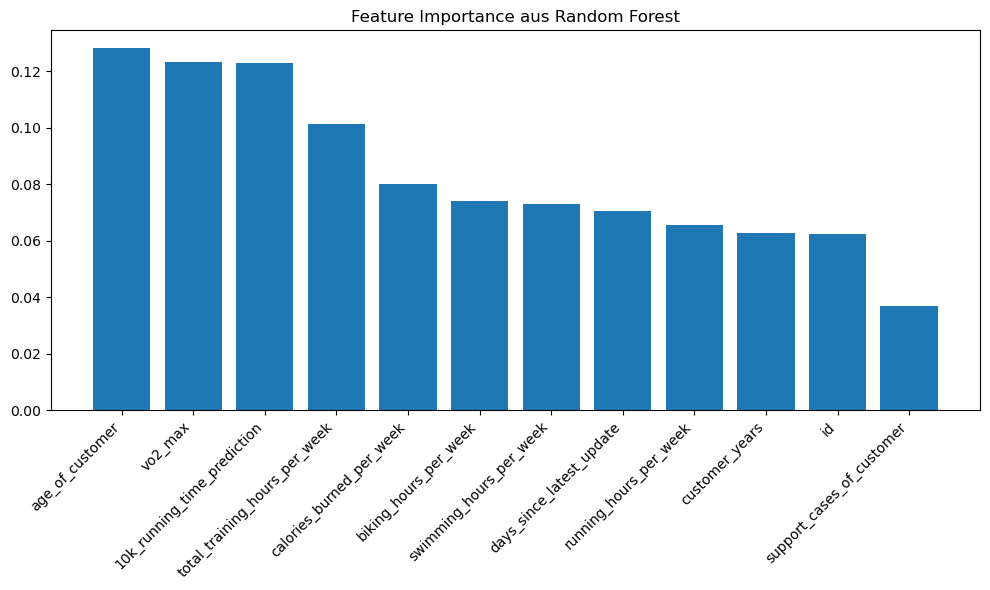

In [66]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
import numpy as np


# Features und Target definieren
X = df_step9[numeric_ohne_target]  # Numerische Features ohne Label
y = df_step9['user_of_latest_model']  # Zielvariable

# 1. ANOVA F-Test für numerische Features
f_selector = SelectKBest(f_classif, k='all')
f_selector.fit(X, y)

# Feature Scores aus ANOVA F-Test
anova_scores = pd.DataFrame({
    'Feature': X.columns,
    'F_Score': f_selector.scores_,
    'P_value': f_selector.pvalues_
})
anova_scores = anova_scores.sort_values('F_Score', ascending=False)

print("ANOVA F-Test Scores:")
print(anova_scores)

# 2. Random Forest Feature Importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Feature Importance aus Random Forest
rf_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
})
rf_importance = rf_importance.sort_values('Importance', ascending=False)

print("\nRandom Forest Feature Importance:")
print(rf_importance)

# 3. Korrelationsmatrix für numerische Features
correlation_matrix = X.corr()

# Identifiziere stark korrelierte Features (z.B. > 0.8)
high_correlation = np.where(np.abs(correlation_matrix) > 0.8)
high_correlation = [(correlation_matrix.index[x], correlation_matrix.columns[y], correlation_matrix.iloc[x, y]) 
                   for x, y in zip(*high_correlation) if x != y and x < y]

print("\nStark korrelierte Features (>0.8):")
for feat1, feat2, corr in high_correlation:
    print(f"{feat1} - {feat2}: {corr:.2f}")

# Kombiniere die Ergebnisse für eine Empfehlung
# Wähle Features basierend auf Importance und geringer Korrelation
important_features = rf_importance[rf_importance['Importance'] > rf_importance['Importance'].mean()]['Feature'].tolist()

print("\nEmpfohlene Features basierend auf Importance und geringer Korrelation:")
print(important_features)

# Optional: Erstelle einen neuen DataFrame nur mit den wichtigsten Features
selected_features = important_features + ['user_of_latest_model']  # Füge Label hinzu
df_step9 = df_step9[selected_features]

# Visualisiere die Feature Importance
plt.figure(figsize=(10, 6))
plt.bar(rf_importance['Feature'], rf_importance['Importance'])
plt.xticks(rotation=45, ha='right')
plt.title('Feature Importance aus Random Forest')
plt.tight_layout()
plt.show()

Hier nun die Feature Selection der kategorischen Variablen:
Nutzt die bereits vorhandenen kategorischen Spalten (categorical_columns)
Führt das Ordinal Encoding durch
Berechnet die Feature Importance für kategorische Features
Visualisiert die Ergebnisse
Wählt wichtige kategorische Features aus
Kombiniert sie mit den bereits ausgewählten numerischen Features


Random Forest Feature Importance (kategorische Features):
                      Feature  Importance
8           update_month_name    0.232196
2                        town    0.161301
1                        ctry    0.155593
3            goal_of_training    0.104818
0                         sex    0.094203
4  preferred_training_daytime    0.090332
5           subscription_type    0.081360
6              color_of_watch    0.049205
7             synchronisation    0.030992

Wichtige kategorische Features:
['update_month_name', 'town', 'ctry']


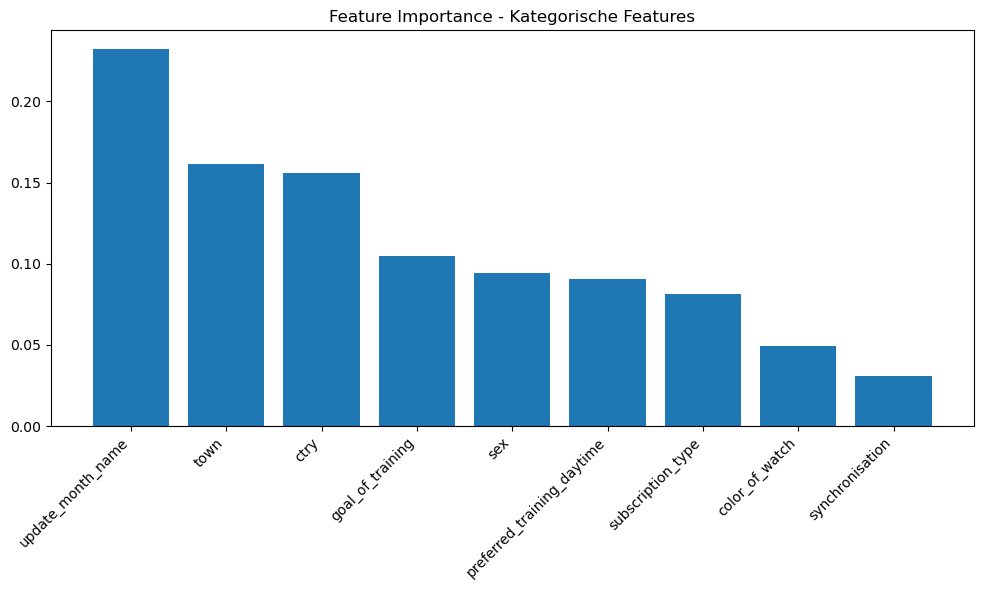


Finale ausgewählte Features (numerisch + kategorisch):
['age_of_customer', 'vo2_max', '10k_running_time_prediction', 'total_training_hours_per_week', 'user_of_latest_model', 'update_month_name', 'town', 'ctry']


In [68]:
# Zurück zum ursprünglichen DataFrame für die kategorische Feature Selection, da im vorherigen Schritt die numerischen ausgesondert wurden
df_temp = df_step0.copy()

# Encoding für kategorische Features
encoder = OrdinalEncoder()
X_cat = pd.DataFrame(encoder.fit_transform(df_temp[categorical_columns]), 
                    columns=categorical_columns)
y_cat = df_temp['user_of_latest_model']

# Random Forest für kategorische Features
rf_cat = RandomForestClassifier(n_estimators=100, random_state=42)
rf_cat.fit(X_cat, y_cat)

# Feature Importance für kategorische Features
rf_importance_cat = pd.DataFrame({
    'Feature': X_cat.columns,
    'Importance': rf_cat.feature_importances_
})
rf_importance_cat = rf_importance_cat.sort_values('Importance', ascending=False)

print("\nRandom Forest Feature Importance (kategorische Features):")
print(rf_importance_cat)

# Wichtige kategorische Features auswählen
important_cat_features = rf_importance_cat[rf_importance_cat['Importance'] > 
                                         rf_importance_cat['Importance'].mean()]['Feature'].tolist()

print("\nWichtige kategorische Features:")
print(important_cat_features)

# Visualisierung der kategorischen Feature Importance
plt.figure(figsize=(10, 6))
plt.bar(rf_importance_cat['Feature'], rf_importance_cat['Importance'])
plt.xticks(rotation=45, ha='right')
plt.title('Feature Importance - Kategorische Features')
plt.tight_layout()
plt.show()

# Finalen DataFrame aktualisieren mit numerischen und kategorischen Features
all_selected_features = selected_features + important_cat_features
df_step9 = df_temp[all_selected_features]

print("\nFinale ausgewählte Features (numerisch + kategorisch):")
print(df_step9.columns.tolist())

In [69]:
run_logistic_regression(df_step9, '9 Feature Selection')
df_score

Accuracy: 0.75, F1-Score: 0.68


,arbeitsschritt,Accuracy,F1-Score
0,step 0,0.770408,0.709677
1,step 1,0.760204,0.711656
2,step 2,0.770408,0.705882
3,step 3,0.770408,0.709677
4,step 4,0.750000,0.687898
5,step 5,0.765306,0.705128
6,step 6,0.765306,0.701299
7,7 Standard-Scaler,0.765306,0.701299
8,7 Standard-Scaler,0.770408,0.709677
9,8 Ordinal Encoding,0.775510,0.714286


# Step 10 Feature Extraction